In [14]:
import torch
import h5py
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
from collections import Counter
from sklearn.utils import resample
import torch.nn.functional as F

In [15]:
# Load the TXT file
labels_df = pd.read_csv('data/0ADD710_gated_full_final.txt', sep='\t')
print(labels_df.shape)

# Map string labels to integers for multi-class
label_mapping = {'T-cells': 0, 'B-cells': 1, 'NK-cells': 2, 'Granulocytes': 3, 'Monocyte/Macrophages': 4}
labels_int = labels_df['Multiclass_5'].map(label_mapping).values

# Open the HDF5 file
with h5py.File('data/0ADD710_gated_full_hierarchical.hdf5', 'a') as hdf5_file:
    
    # Check if 'targets' dataset exists, if not, create it
    if 'targets' in hdf5_file.keys():
        print("'targets' dataset already exists. Overwriting with new labels.")
        del hdf5_file['targets']  # Delete the old 'targets' dataset
    
    # Create 'targets' dataset with integer labels
    hdf5_file.create_dataset('targets', data=labels_int)

print("Integer labels appended to 'targets' dataset in HDF5 file successfully.")


(29028, 93)
'targets' dataset already exists. Overwriting with new labels.
Integer labels appended to 'targets' dataset in HDF5 file successfully.


In [32]:
torch.manual_seed(42)

# file_path = 'data/0ADD710_gated_full_hierarchical.hdf5'
file_path = 'data/0ADD710_gated_full_multi.hdf5'
batch_size = 256
learning_rate = 0.003
weight_decay = 0.0005
num_epochs = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cpu


In [33]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        # Open the HDF5 file
        self.hdf5_file = h5py.File(file_path, 'r')

        # Get the number of samples in the dataset
        # self.num_samples = len(self.hdf5_file['images'])
        self.num_samples = len(self.hdf5_file['cropped_images'])

    def permute(self, image):
        if len(image.shape) == 3:
            return image.permute(2, 0, 1)
        else:
            return image.permute(0, 3, 1, 2)

    def __getitem__(self, index):
        # Get the image and target from the HDF5 file
        
        image = self.hdf5_file['cropped_images'][index, :, :, [0, 2]] / 65535.0
        # image = self.hdf5_file['images'][index, 12:33, 12:33, [0, 2]] / 65535.0
        target = self.hdf5_file['targets'][index]

        # Convert the image and target to PyTorch tensors
        image = self.permute(torch.from_numpy(image).float())
        target = torch.from_numpy(np.asarray(target)[..., np.newaxis]).float()

        # Apply any data augmentations or transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return self.num_samples

In [34]:

# Define models
class BinaryClassificationModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BinaryClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(32) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(2, 2)

        # self.avg_pool = nn.AvgPool2d(2, 2) 
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(in_features=256, out_features=32)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.out = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)

        # print(f"Before flatten shape: {x.shape}")
        x = self.flatten(x)
        # print(f"After flatten shape: {x.shape}")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.out(x)
        x = self.sigmoid(x)

        return x

    

In [35]:
class LymphClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(LymphClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(32) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(2, 2)

        # self.avg_pool = nn.AvgPool2d(2, 2) 
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(in_features=256, out_features=32)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.out = nn.Linear(in_features=32, out_features=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)

        # print(f"Before flatten shape: {x.shape}")
        x = self.flatten(x)
        # print(f"After flatten shape: {x.shape}")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.out(x)
        return F.log_softmax(x, dim=1)  # Use log softmax for a stable output of probabilities


In [36]:
class MyeloClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(MyeloClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(32) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(2, 2)

        # self.avg_pool = nn.AvgPool2d(2, 2) 
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(in_features=256, out_features=32)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.out = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)


        # print(f"Before flatten shape: {x.shape}")
        x = self.flatten(x)
        # print(f"After flatten shape: {x.shape}")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.out(x)
        x = self.sigmoid(x)

        return x


In [37]:
def calculate_mean_std(loader):
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0

    for images, _ in loader:
        # Assuming images are in shape (batch_size, channels, height, width)
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

# Using the data loader to calculate mean and std
loader = DataLoader(HDF5Dataset(file_path), batch_size=10, shuffle=False)
mean_values, std_values = calculate_mean_std(loader)
print(f"Calculated mean: {mean_values}")
print(f"Calculated std: {std_values}")

rotation_range = (-85, 85)  # Desired rotation angles

# Define transformations for the training data
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(rotation_range),  # Rotation with a range
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=mean_values, std=std_values)  # Normalize images
])

# Transformations for the validation and test sets should not contain any augmentation.
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

Calculated mean: tensor([0.0494, 0.0602])
Calculated std: tensor([0.0929, 0.0839])


In [38]:
# load the pre-trained model
binary_model = BinaryClassificationModel()
binary_model_dict = torch.load('0ADD710_binary_classification_model.pth')
binary_model.load_state_dict(binary_model_dict)
binary_model.eval()

lymph_model = LymphClassifier()
lymph_model_dict = torch.load('0ADD710_gated_full_lymph.pth')
lymph_model.load_state_dict(lymph_model_dict)
lymph_model.eval()

myelo_model = MyeloClassifier()
myelo_model_dict = torch.load('0ADD710_myelo_classifier.pth')
myelo_model.load_state_dict(myelo_model_dict)
myelo_model.eval()


MyeloClassifier(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(

In [39]:
# Load the dataset 
dataset = HDF5Dataset(file_path, transform=test_transforms)
dataset_size = len(dataset)
dataloader = DataLoader(dataset, batch_size=dataset_size, shuffle=False)

In [40]:
# Constants for class labels
LYMPH_LABEL_OFFSET = 0  # 'T-cells': 0, 'B-cells': 1, 'NK-cells': 2
MYELO_LABEL_OFFSET = 3  # 'Granulocytes': 3, 'Monocyte/Macrophages': 4

# Threshold for binary classification
BINARY_THRESHOLD = 0.5

# Predict with the binary model
binary_predictions = []
counter = 0
for inputs, _ in dataloader:
    outputs = binary_model(inputs)
    outputs.cpu().detach().numpy()
    predictions = (outputs.squeeze() > BINARY_THRESHOLD).long()
    binary_predictions.append(predictions)
binary_predictions = torch.cat(binary_predictions)

print(len(binary_predictions))


# Separate the dataset based on binary predictions
lymph_indices = torch.where(binary_predictions == 1)[0]  # Indices for lymphocytes
myelo_indices = torch.where(binary_predictions == 0)[0]  # Indices for myelocytes

# Create data subsets and DataLoaders
lymph_dataset = HDF5Dataset(file_path, transform=test_transforms)
myelo_dataset = HDF5Dataset(file_path, transform=test_transforms)
lymph_dataset = Subset(lymph_dataset, lymph_indices.tolist())
myelo_dataset = Subset(myelo_dataset, myelo_indices.tolist())

lymph_dataset_size = len(lymph_dataset)
myelo_dataset_size = len(myelo_dataset)

lymph_dataloader = DataLoader(lymph_dataset, batch_size=lymph_dataset_size, shuffle=False)
myelo_dataloader = DataLoader(myelo_dataset, batch_size=myelo_dataset_size, shuffle=False)

# Predict with the myelo model (binary)
myelo_predictions = []
myelo_true_labels = []

for inputs, labels in myelo_dataloader:
    outputs = myelo_model(inputs)
    predictions = (outputs.squeeze() > BINARY_THRESHOLD).long()
    myelo_predictions.append(predictions + MYELO_LABEL_OFFSET)  # Adjust class indices with offset
    myelo_true_labels.append(labels)  # Collect true labels

# Concatenate results from list to a single tensor
myelo_predictions = torch.cat(myelo_predictions)
myelo_true_labels = torch.cat(myelo_true_labels)

print("myelo")
print(len(myelo_predictions))
print(len(myelo_true_labels))

# Predict with the lymph model (multi-class)
lymph_predictions = []
lymph_true_labels = []

for inputs, labels in lymph_dataloader:
    outputs = lymph_model(inputs)
    predictions = outputs.argmax(dim=1)
    lymph_predictions.append(predictions + LYMPH_LABEL_OFFSET)  # Adjust class indices with offset
    lymph_true_labels.append(labels)  # Collect true labels

# Concatenate results from list to a single tensor
lymph_predictions = torch.cat(lymph_predictions)
lymph_true_labels = torch.cat(lymph_true_labels)

print("lymph")
print(len(lymph_predictions))
print(len(lymph_true_labels))




1260
myelo
564
564
lymph
696
696


In [44]:
# Combine the predictions and true labels into a single tensor or structure
combined_predictions = torch.zeros(len(dataset), dtype=torch.long)
combined_true_labels = torch.zeros(len(dataset), dtype=torch.long)

# Use .squeeze() to ensure the labels are a flat tensor
combined_predictions[lymph_indices] = lymph_predictions
combined_predictions[myelo_indices] = myelo_predictions

label_mapping = {0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
combined_predictions = combined_predictions(label_mapping)


combined_true_labels[lymph_indices] = lymph_true_labels.squeeze().long()
combined_true_labels[myelo_indices] = myelo_true_labels.squeeze().long()


print("combined")
print(len(combined_predictions))
print(len(combined_true_labels))

TypeError: 'Tensor' object is not callable

Overall Accuracy: 44.92%


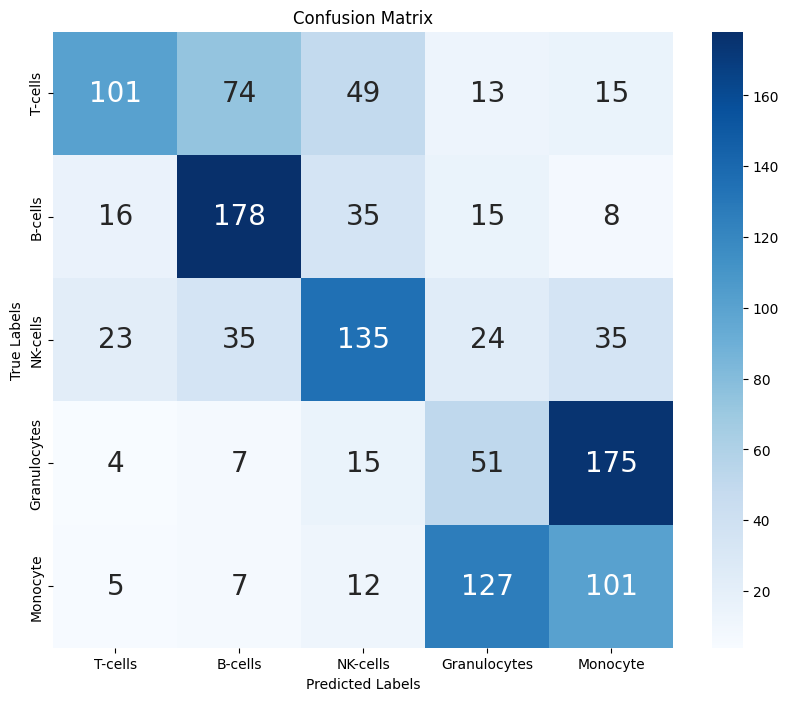

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Use the combined_true_labels directly
true_labels = combined_true_labels.numpy()

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, combined_predictions.numpy())
print(f"Overall Accuracy: {accuracy:.2%}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, combined_predictions, labels=list(label_mapping.values()))

label_mapping = {'T-cells': 0, 'B-cells': 1, 'NK-cells': 2, 'Granulocytes': 4, 'Monocyte': 3}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 20},
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
